# Plot the data
Read the file ["Readme.ipynb"](Readme.ipynb) for more information.

## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
%run get_data.ipynb
print("All data is ready!")

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!
All data is ready!


## Control
Set variables to "True" to trigger the action described by the comment and the variable's name.

In [ ]:
show_correlation_matrix_big = False

## Function to calculate the probability of correlations between two arrays

In [3]:
%run get_scaled_correlation.ipynb

In [4]:
def sort_AdmUnitIDs_by_population_density(AdmUnitIds):
    county_by_population_density = dict()
    for AdmUnitID, county in counties_geography.items():
        if county['population_density'] in county_by_population_density.keys():
            raise Exception("The population density " + str(county['population_density']) +
                            "seems to be relate to two counties")
        else:
            county_by_population_density[county['population_density']] = AdmUnitID
    pop_densitys = list(county_by_population_density.keys())
    pop_densitys.sort()
    AdmUnitIds = list()
    for e in pop_densitys:
        AdmUnitIds.append(county_by_population_density[e])

In [5]:
AdmUnitIds = list(covid19.keys())
# sort_AdmUnitIDs_by_population_density(AdmUnitIds)

In [6]:
def get_correlation_matrix(get_sum_of_all_counties_correlations, max_shift):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId1 in AdmUnitIds:
        for AdmUnitId2 in AdmUnitIds:
            if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[AdmUnitIds.index(AdmUnitId1)]
                [AdmUnitIds.index(AdmUnitId2)] != 0): continue
            if get_sum_of_all_counties_correlations:
                correlation = get_scaled_correlation(covid19[AdmUnitId1]['incidences'],
                                                     covid19[AdmUnitId2]['incidences'],
                                                    max_shift=max_shift)[0]
                offset = (sum(correlation[:len(correlation)//2])
                          - sum(correlation[len(correlation)//2 + 1:]))
            else:
                offset = get_scaled_correlation(covid19[AdmUnitId1]['incidences'],
                                                covid19[AdmUnitId2]['incidences'],
                                                max_shift=max_shift)[3]
        
            i1, i2 = (AdmUnitIds.index(AdmUnitId1), AdmUnitIds.index(AdmUnitId2))
            correlation_matrix[i1][i2]=offset
            correlation_matrix[i2][i1]=-offset
    return correlation_matrix

In [7]:
correlation_matrizes = list()
for config in [(False, 50), (False, 30), (False, 14), (True, 200)]:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

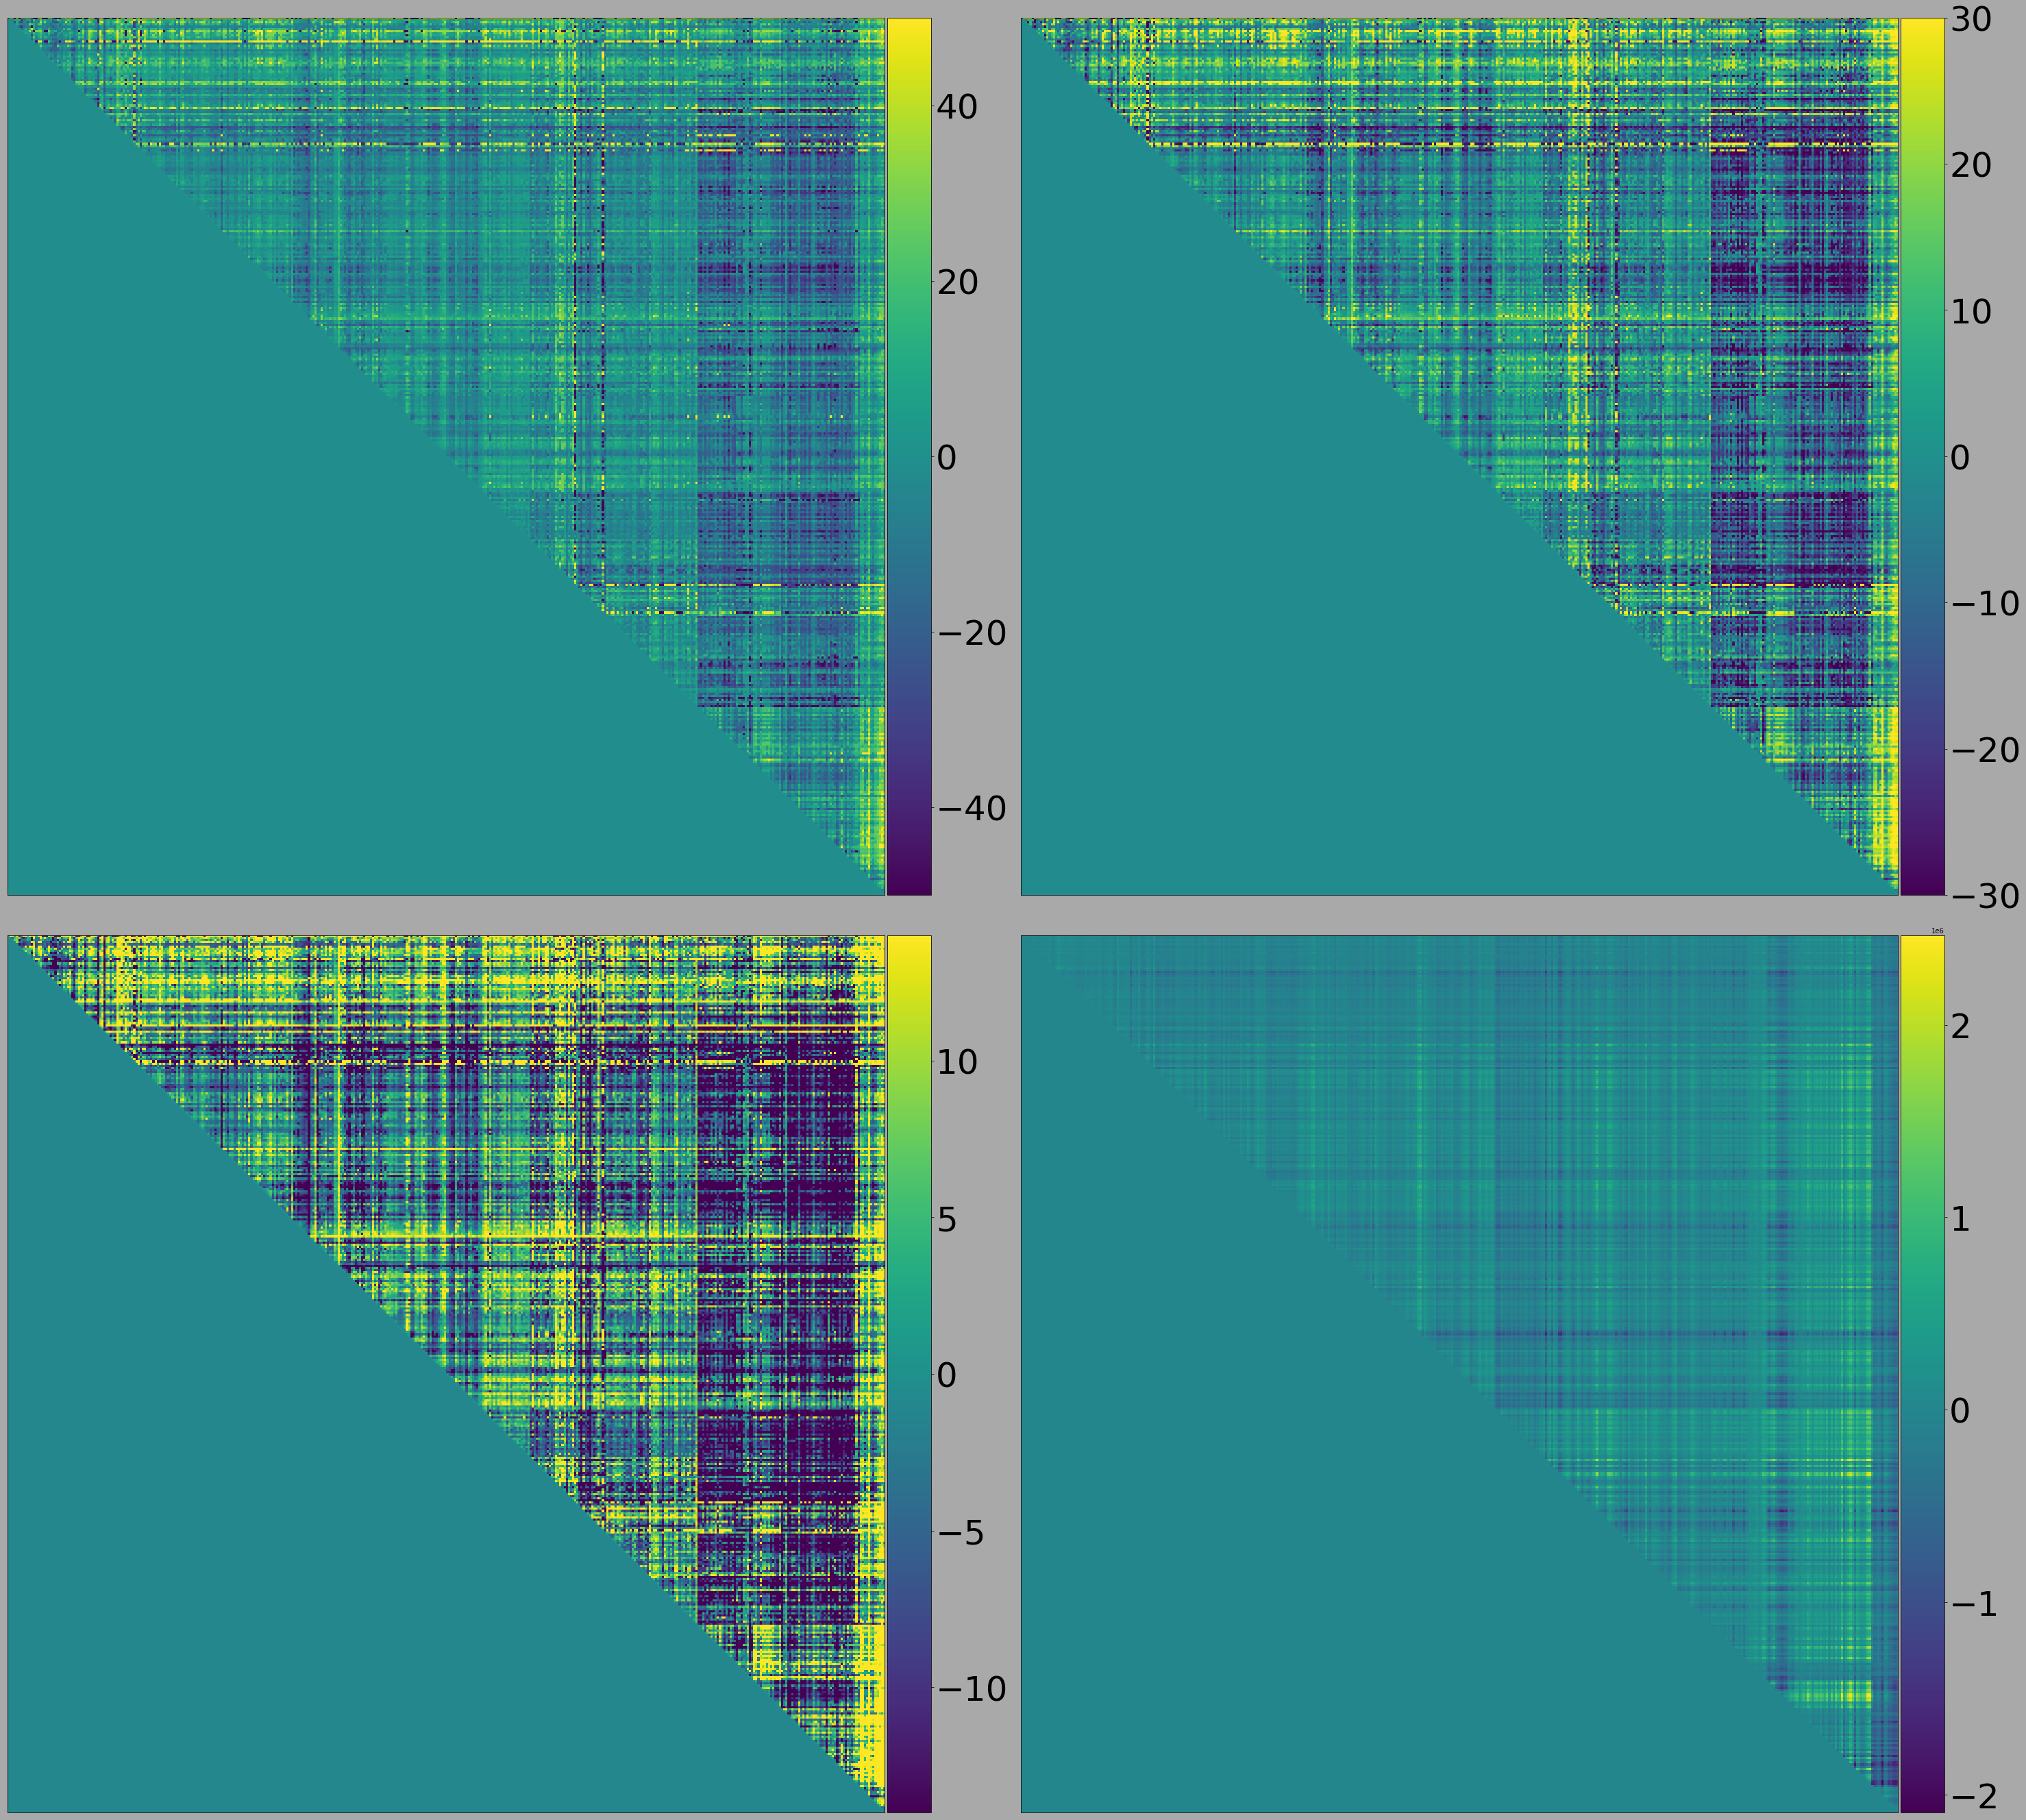

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (40, 50), facecolor='darkgrey')
fig.tight_layout(h_pad=-90, w_pad=10)
i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

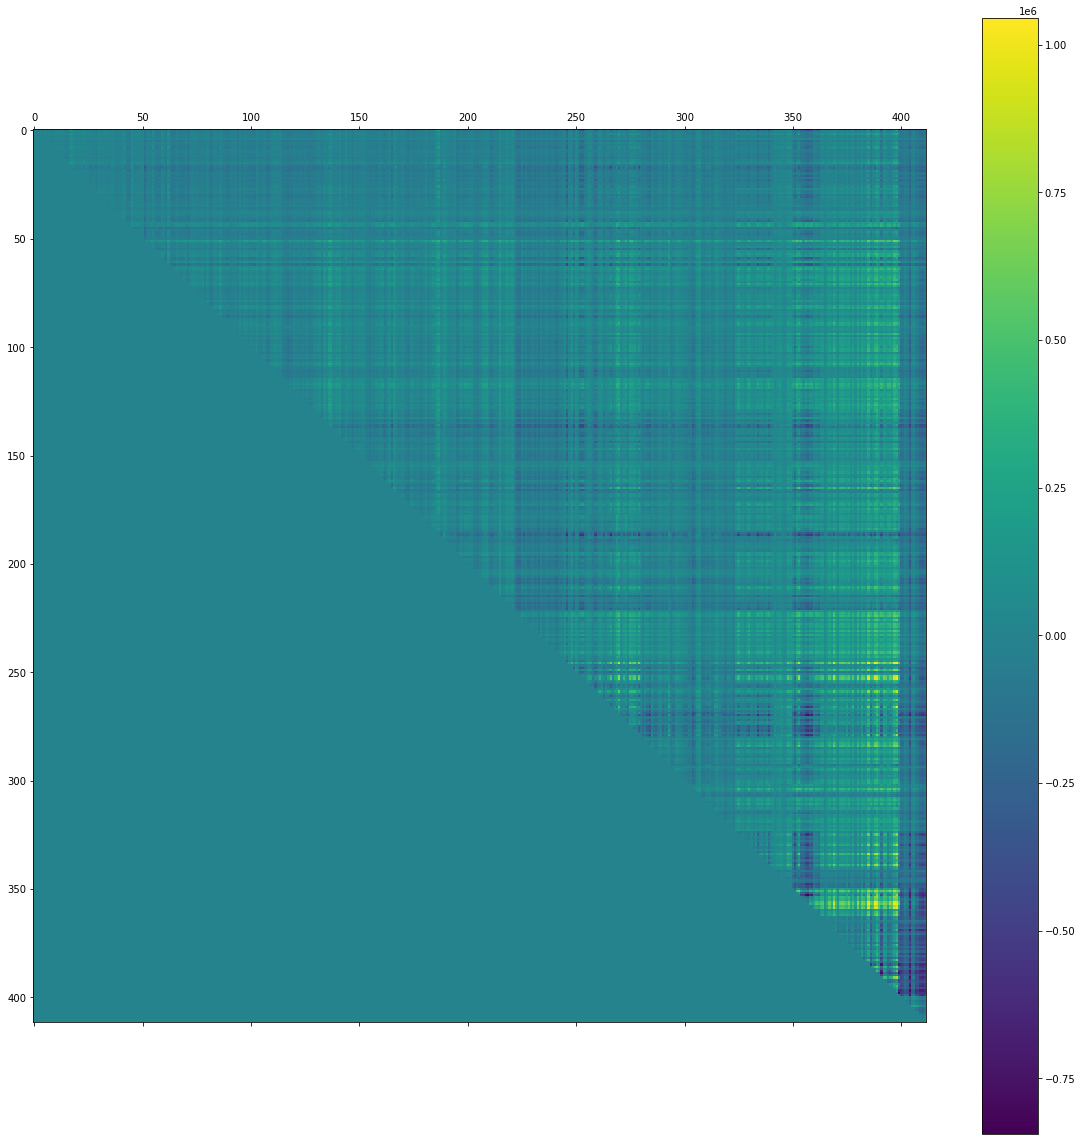

In [9]:
if show_correlation_matrix_big:
    matfig = plt.figure(figsize=(20,20))
    plt.matshow(get_correlation_matrix(True, 100), fignum=matfig.number)
    plt.colorbar()

In [10]:
average_correlation = dict()
for row_index in range(len(correlation_matrix)):
    row = correlation_matrix[row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, ralated to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlation[AdmUnitID]=-(sum(row)/len(row))

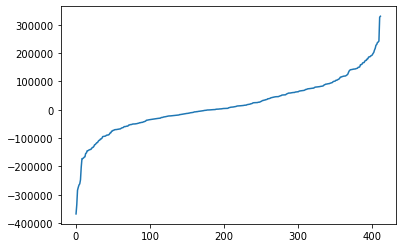

In [11]:
average_correlation_copy = list(average_correlation.values())[:]
average_correlation_copy.sort()
plt.plot(average_correlation_copy)

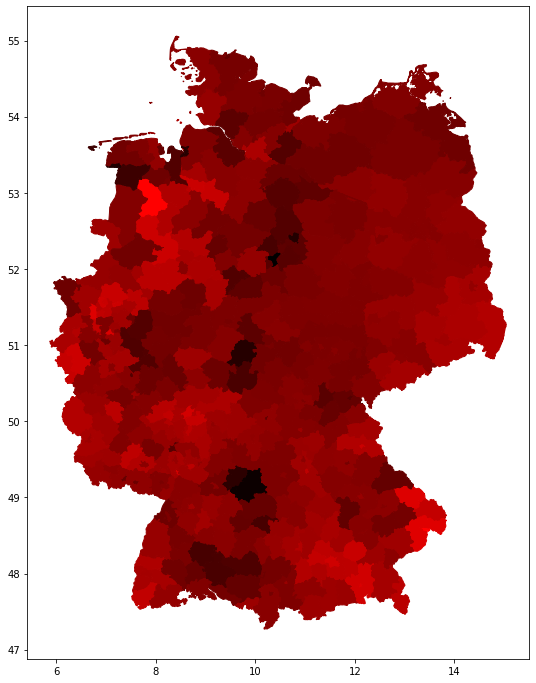

In [12]:
plt.figure(figsize=(9, 12))    # enlarge plot
for AdmUnitID, correlation in average_correlation.items():
    color = ((correlation - average_correlation_copy[0])/
             (average_correlation_copy[-1]-average_correlation_copy[0]), 0, 0)
    for polygon in counties_geography[AdmUnitID]['geometry']:
        x,y = np.array(polygon).T
        plt.fill(x, y, color=color)
plt.show()

## Verteilung der Inzidenzen in Deutschland

66805.59370409738


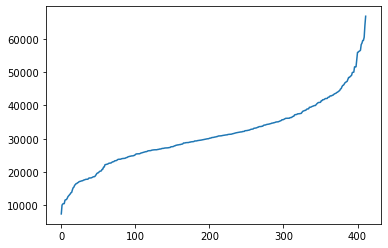

In [13]:
incidences_of_counties_acc = list()
for county in covid19.values():
    incidences_of_counties_acc.append(sum(county["incidences"]))
incidences_of_counties_acc.sort()
print(incidences_of_counties_acc[-1])
plt.plot(incidences_of_counties_acc)

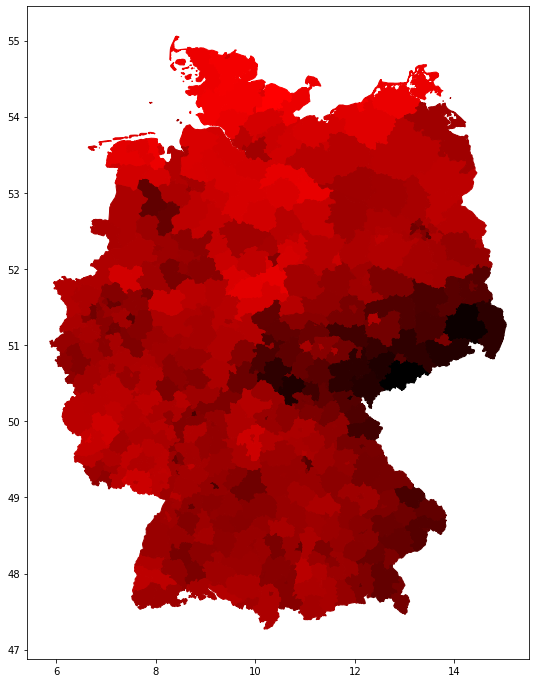

In [14]:
plt.figure(figsize=(9, 12))    # enlarge plot
for AdmUnitID, county in covid19.items():
    color = (1-((sum(county["incidences"]) - incidences_of_counties_acc[0])/
             (incidences_of_counties_acc[-1] - incidences_of_counties_acc[0])), 0, 0)
    for polygon in counties_geography[AdmUnitID]['geometry']:
        x,y = np.array(polygon).T
        plt.fill(x, y, color=color)
plt.show()